In [45]:
# Date specification
Year = 2022
Month = 2
Day = 17
Hour = 18

plevel = 1000

domain = 'CONUS' #WMIX, Northeast, CONUS

In [46]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [47]:
# Formating into datetime
dateTime = dt(Year,Month,Day, Hour)
timeStr = dateTime.strftime("%Y-%m-%d %H UTC")

# Vertical level specificaton
levelStr = str(plevel) # Use for the figure title
constrainLat, constrainLon = (10,10) # Changes the "Amount of tatotal data "

if domain == 'Northeast':
    latN = 52.0
    latS = 30.0
    lonW = -97
    lonE = -62
    skip = 2
    minimum = -50 # Min value = -14
    maximum = 50 # Max value = 35
    interval = .5 # Interval between each number


elif domain == "WMIX":
    latN = 48.25
    latS = 42.00
    lonW = -79.0
    lonE = -70.0
    skip = 1
    minimum = -16 # Min value = -14
    maximum = 16 # Max value = 35
    interval = .5 # Interval between each number


elif domain == 'CONUS':
    # Figure Borders for CONUS
    lonW = -120
    lonE = -72
    latS = 25
    latN = 52
    skip =2
    minimum = -50 # Min value = -14
    maximum = 50 # Max value = 35
    interval = .5 # Interval between each number
    

# Combines information to make a list of integers counting up from -14 to 35, every two numbers.
sidebar = np.arange(minimum, maximum, interval) # creates object from defined mxa, min and interval values

cLat, cLon = (latS + latN)/2, (lonW + lonE)/2 # Central lat and lon
latRange = np.arange(latS-5,latN+5,1) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW-5,lonE+5,1) # Need to match longitude values to those of the coordinate variable

dsT = xr.open_dataset (f'/cfsr/data/{Year}/t.{Year}.0p5.anl.nc') # Temperature
T = dsT['t'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange) # Temperature defined by lat and lon
T = T.metpy.convert_units('degC') # Convert temperature using MetPy unit conversion

dsU = xr.open_dataset (f'/cfsr/data/{Year}/u.{Year}.0p5.anl.nc') # U Wind 
U = dsU['u'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange) # U wind defined by lat and lon
U = U.metpy.convert_units('kts') # Convert u wind using MetPy unit conversion

dsV = xr.open_dataset (f'/cfsr/data/{Year}/v.{Year}.0p5.anl.nc') # V Wind
V = dsV['v'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange) # V wind defined by lat and lon
V = V.metpy.convert_units('kts') # Convert v wind using MetPy unit conversion

#Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.
lats = T.lat
lons = T.lon

/free/ktyle/anaconda3/envs/aug21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'c', 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


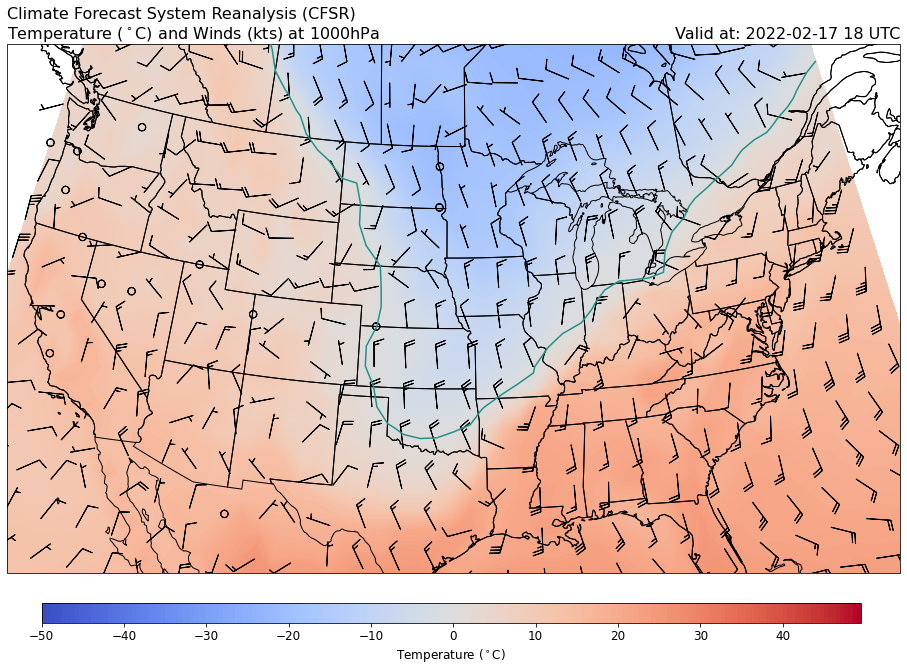

In [48]:
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat) # Creates a lambert conformal defined by central lat and lon
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'
tl0 = 'Climate Forecast System Reanalysis (CFSR)'
tl1 = f'Temperature ($^\circ$C) and Winds (kts) at {plevel}hPa'
tl2 = str('Valid at: '+ timeStr)
title_line = (tl0 + '\n' + tl1)

fig = plt.figure(figsize=(16,16)) # Increase size to adjust for the constrained lats/lons
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_title(title_line,fontsize=16,loc = 'left')
ax.set_title(tl2,fontsize=16,loc = 'right')

ax.set_extent ([lonW,lonE,latS,latN])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
CF = ax.contourf(lons,lats,T, levels=sidebar,transform=proj_data,cmap='coolwarm') #coolwarm_r. : _r to reverse colorwave
ax.barbs(lons[::skip],lats[::skip],U[::skip,::skip].values, V[::skip,::skip].values, transform=proj_data)

if domain == 'WMIX':
    colorbar_axes = fig.add_axes([0.155, 0.12, .711, .0175])# Left Bottom Width Height
elif domain == 'Northeast':
    colorbar_axes = fig.add_axes([0.155, 0.185, .711, .0175])# Left Bottom Width Height
elif domain == 'CONUS':
    colorbar_axes = fig.add_axes([0.155, 0.23, .711, .0175])# Left Bottom Width Height    
    
W = ax.contour(lons,lats,T, levels=0, transform=proj_data, c = 'white',linewidth = 4, zorder = 5) #coolwarm_r. : _r to reverse colorwave

cbar = plt.colorbar(CF,shrink=0.5,cax = colorbar_axes, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xlabel("Temperature ($^\circ$C)",fontsize=12)
plt.savefig (f'{plevel}T&W_{timeStr}.png') # Save Figure Name